In [ ]:
!pip install langchain langgraph langchain-google-genai langchain-core langchain-community langchain-experimental koreanize-matplotlib

In [ ]:
!pip install langchain-openai

In [ ]:
import pandas as pd
import re
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Annotated, Literal, Tuple
from typing_extensions import TypedDict
from langchain.schema import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI

import base64
import io
import os
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
google_api_key = "" # @param {"type":"string"}
openai_api_key = "" # @param {"type":"string"}

In [ ]:
# 환경변수에 Goolge API Key 등록

os.environ["google_api_key"] = google_api_key
os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["openai_api_key"] = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

In [ ]:
# 데이터프레임 불러오기

url = "/content/drive/MyDrive/_sample_data/titanic.csv"
df = pd.read_csv(url)

In [ ]:
# 데이터프레임 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 1. State 정의  
LangGraph의 핵심인 State 클래스를 정의합니다. 이 클래스는 에이전트가 실행되는 동안 필요한 모든 정보를 저장합니다:
- `messages`: 대화 히스토리
- `code`: 실행할 Python 코드
- `code_result`: 코드 실행 결과

In [ ]:
# 그래프 상태 정의

class State(TypedDict):
    messages : Annotated[list, add_messages] # History
    code : Annotated[str, "Python code"]
    code_result : Annotated[str, "Python code Result"]

ChatGPT 모델을 설정하고, Python 코드 실행 도구를 연결합니다.  
temperature=0은 일관된 응답을 위해 창의성을 최소화합니다.  

In [ ]:
# LLM 로드
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                            temperature=0.,
                            convert_system_message_to_human=True,
                            )

# llm =ChatOpenAI(model="gpt-4o-mini",
#            temperature=0.)

# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-04-17",
#                             temperature=0.,
#                             convert_system_message_to_human=True,
#                             )

# 파이썬 코드 실행 도구 정의
tool = PythonAstREPLTool(name="python_repl_ast",
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                         locals={"df":df})

In [ ]:
tool.invoke("```python for i in range(10): print(i)")

'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\n'

### 1-1 Langchain  
기존 랭체인에서의 활용방법을 비교하기 위해 정의된 세션입니다.  
랭그래프로 같은 동작을 하면 어떻게 달라지는지 비교해보세요!  

In [ ]:
# 데이터셋 제목, 요약 생성 함수

def create_title_summary(df:pd.DataFrame) -> Tuple[str, str]:

    # 데이터셋이 너무 클 시 3000개의 샘플만 제공
    df_sampled = df.sample(n=3000) if len(df) > 3000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.

            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.


            제목:
            요약:

            """
            )

    chain = prompt | llm

    # chain.invoke는 AI Message객체를 반환함. 그 중 str 형태인 content만 추출
    result = chain.invoke({"df":df_sampled})

    title = "Untitled"
    summary = "No Summary"

    # 요약 양식에 맞지 않는 답변을 할 시 "Untitle"과 "No Summary"로 설정하도록 예외처리
    try:
        content = result.content
        content = content.replace("## 결과:\n\n", "")
        lines = content.split("\n")
        title = lines[0].replace("## 제목:", "").strip()
        summary = "\n".join(lines[1:]).replace("## 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====")

    return title, summary

In [ ]:
# 제목, 요약 생성

title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====


In [ ]:
print("제목 : ", title)
print("요약 : ", summary)

제목 :  타이타닉호 생존자 예측을 위한 승객 데이터 분석
요약 :  본 데이터셋은 타이타닉호에 탑승했던 승객 891명의 정보를 담고 있으며, 각 승객의 생존 여부, 객실 등급, 성별, 나이, 동반 가족 수, 티켓 정보, 요금, 선실 정보, 승선 항구 등 다양한 변수를 포함하고 있습니다. 이 데이터는 타이타닉호 침몰 사고 당시 생존에 영향을 미친 요인을 분석하고, 머신러닝 모델을 통해 생존자를 예측하는 데 활용될 수 있습니다. 특히, 성별, 객실 등급, 나이와 같은 변수가 생존 여부에 미치는 영향력을 파악하는 데 유용합니다.


In [ ]:
# LLM에게 도구 할당

llm_with_tools = llm.bind_tools([tool])

In [ ]:
llm_with_tools.invoke("1부터 10까지  출력하는 파이썬 코드")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_ast', 'arguments': '{"query": "for i in range(1, 11):\\n  print(i)"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--d0e9bea7-e07c-443f-a6a5-5498ff951a42-0', tool_calls=[{'name': 'python_repl_ast', 'args': {'query': 'for i in range(1, 11):\n  print(i)'}, 'id': '804ba5b1-ebea-4861-a97c-72ff2326265b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 74, 'output_tokens': 23, 'total_tokens': 97, 'input_token_details': {'cache_read': 0}})

In [ ]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [ ]:
# LLM의 응답을 HistoryChecker 클래스 구조에 맞춰 파싱하도록 설정

history_checker = llm.with_structured_output(HistoryChecker)

In [ ]:
history_checker.invoke("오늘 인천 날씨는 어때?")

HistoryChecker(yes_no='no')

In [ ]:
# 히스토리 기반 답변 분기를 위한 함수 설정

def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | history_checker

    result = chain.invoke({"history":state["messages"][:-1],
                            "query":state["messages"][-1]})

    return result.yes_no

### 2. 워크플로우 노드 함수들
각 노드는 특정 작업을 수행합니다:
- `history_node`: 이전 대화 확인
- `select`: 코드 실행 여부 결정
- `code_executor`: Python 코드 실행
- `code_response`: 결과 정리 및 응답

In [ ]:
# 식별을 위한 노드

def history_node(state:State):

    return

In [ ]:
# 도구 사용 여부 결정 노드

def select(state:State):
    prompt = PromptTemplate.from_template("""
            당신은 데이터 분석가입니다.
            당신은 데이터프레임인 df를 활용할 수 있습니다.
            당신이 활용 가능한 데이터프레임의 예시는 아래와 같습니다.
            아래의 예시는 `print(df.head())`의 실행결과입니다.
            활용 가능한 데이터프레임을 갖고 있으니 데이터프레임을 새로 생성할 필요 없습니다.
            코드에 한글이 필요하다면 `import koreanize_matplotlib`을 사용하세요.

            당신은 'python_repl_ast'라는 파이썬 코드 실행 도구만을 가지고 있습니다.
            아래의 내용을 참고하여 질문에 대한 코드를 생성합니다.

            df : {df}

            title : {title}
            summary : {summary}

            query : {query}
            """
            )

    chain = prompt | llm_with_tools

    result = chain.invoke({"df":df.head(),
                           "title":title,
                            "summary":summary,
                            "query":state["messages"][-1].content})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls

        # 코드 추출
        code = tool_calls[0]["args"]["query"]
        return {"code": code}
    else:
        # 도구 사용을 안한다면 코드는 공백으로 설정
        return {"code":""}

In [ ]:
# 코드 실행 노드

def code_executor(state:State):

    try:
        # 코드 실행 결과인 이미지 추출
        if "plt" in state["code"] or "sns" in state["code"]:
            save_fig = """
import io
import base64

buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)

encoded = base64.b64encode(buf.read()).decode("utf-8")

print(encoded)
"""

            execute_code = state["code"] + save_fig

            result = tool.invoke(execute_code)

            return {"code_result":result}
        # 시각화가 아닌 경우 코드만 실행
        else:
            result = tool.invoke(state["code"])
            return {"code_result":result}
    except:
        return {"code_result": ""}

In [ ]:
# 코드에 의한 답변 노드

def code_response(state:State):
    prompt = ChatPromptTemplate.from_messages([
        ("system", """코드 : {code} \n
                    결과 : {code_result}
        당신은 주어진 코드와 코드 결과를 바탕으로 질의에 대해 답변합니다.
        절대 코드에 대해 설명하지마세요.
        독자는 프로그래머가 아닙니다.
        항상 출력되는 값을 기준으로 설명합니다.
        숫자가 매우 중요합니다. 숫자에 대한 정보를 잊지 마세요.
        데이터 분석과 관련된 코드가 입력된다면 항상 인사이트를 포함하세요. """),
        ("human", '{query}')
    ])

    chain = prompt | llm

    result = chain.invoke({"code":state["code"],
                        "code_result":state["code_result"],
                        "query":state["messages"][-1]})

    return { "messages": result}

In [ ]:
# 기억 및 일반 응답 노드

def response(state:State):
    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | llm

    result = chain.invoke({"history":state["messages"][:-1],
                           "query":state["messages"][-1]})

    return {"answer":result.content,
            "messages":result}

### 3. 워크플로우 그래프 구축
StateGraph를 사용해 노드들을 연결하고 실행 흐름을 정의합니다.
조건부 엣지를 통해 상황에 따라 다른 경로로 분기할 수 있습니다.

In [ ]:
# 그래프 정의

graph_builder = StateGraph(State)

In [ ]:
# 노드 및 엣지 정의

graph_builder.add_node("history_node", history_node)
graph_builder.add_node("select", select)
graph_builder.add_node("code_executor", code_executor)
graph_builder.add_node("code_response", code_response)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                                    history_check,
                                    {
                                    "no":"select",
                                     "yes":"response"
                                     }
                                     )
graph_builder.add_edge("select", "code_executor")
graph_builder.add_edge("code_executor", "code_response")
graph_builder.add_edge("code_response", END)
graph_builder.add_edge("response", END);

In [ ]:
# 메모리 설정 및 그래프 컴파일

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

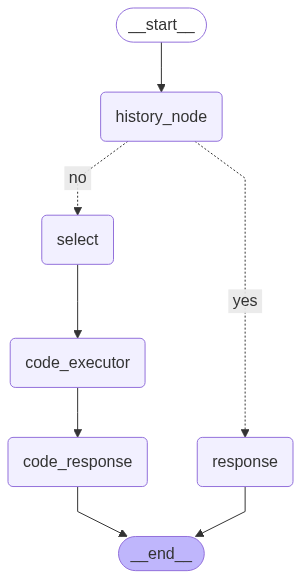

In [ ]:
# 그래프 시각화
# 가끔 "ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)"라는 에러가 발생
# 시간 초과로 그래프 생성에 실패했다는 메시지일뿐 기능과는 관계없으니 진행해도 괜찮습니다.

graph

### 4. 에이전트 실행 함수  
사용자 질문을 받아 전체 워크플로우를 실행하고, 실시간으로 결과를 스트리밍합니다.
RunnableConfig로 실행 제한(recursion_limit)을 설정하여 무한 루프를 방지합니다.

In [ ]:
# 사용할 설정값 정의

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "12"})

In [ ]:
# 출력 함수 정의
# mode = "values" : 상태의 키, 값의 형태로 반환
# mode = "updates" : 업데이트되는 값만 반환

def streaming(query, config, mode="values"):

    result = graph.stream({"messages":("user", query)}, config=config, stream_mode=mode)

    if mode == "values":
        for step in result:
            for k, v in step.items():
                if k == "messages":
                    v[-1].pretty_print()
                    print("\n\n")
    elif mode == "updates":
        for step in result:
            for k,v in step.items():
                print(f"\n\n=== {k} ===\n\n")
                print(v)

    return

### 5. 데이터 분석 실행 예제 1   
설정된 LangGraph 에이전트를 사용하여 타이타닉 데이터 분석을 수행합니다:
- 생존 여부별 승객 수 분석
- 나이별 승객 분포

================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘



================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘





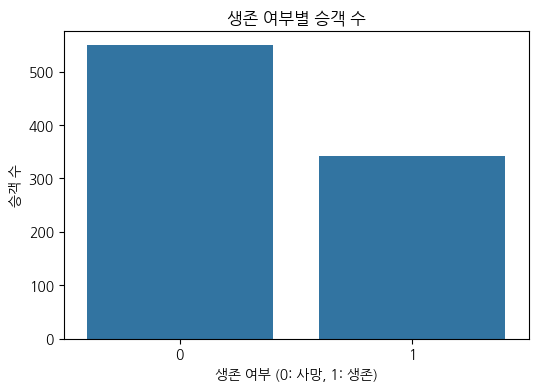

사망 비율: 0.62
생존 비율: 0.38
================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘



================================== Ai Message ==================================

제공된 코드는 타이타닉호 승객 데이터를 사용하여 생존 여부에 따른 승객 수를 시각화하고, 생존 및 사망 비율을 계산하는 코드입니다.

**시각화 결과:**

*   **생존 여부별 승객 수:** 그래프를 통해 사망자 수가 생존자 수보다 더 많다는 것을 알 수 있습니다.

**생존/사망 비율:**

*   **사망 비율:** 0.62
*   **생존 비율:** 0.38

**인사이트:**

타이타닉호 침몰 당시, 승객의 약 62%가 사망하고 38%만이 생존했습니다. 이는 당시 상황이 매우 비극적이었음을 보여줍니다.





<Figure size 640x480 with 0 Axes>

In [ ]:
streaming("생존자 비율 시각화하고 인사이트 제공해줘", config)

In [ ]:
streaming("아까 내가 질문했던 내용 다시 알려줘", config)

================================ Human Message =================================

아까 내가 질문했던 내용 다시 알려줘



================================== Ai Message ==================================

이전 질문은 "생존자 비율 시각화하고 인사이트 제공해줘" 였습니다.





In [ ]:
streaming("아까 물어봤던 숫자들 다 더하면 몇인지 알려줘", config)

================================ Human Message =================================

아까 물어봤던 숫자들 다 더하면 몇인지 알려줘



================================== Ai Message ==================================

이전 대화에서 언급된 숫자는 다음과 같습니다.

*   사망 비율: 0.62
*   생존 비율: 0.38

이 두 숫자를 더하면 0.62 + 0.38 = 1 입니다.





### 6. 데이터 분석 실행 예제 2  
설정된 LangGraph 에이전트를 재사용하여 데이터 로드와 도구를 재정의, 올림픽 데이터 분석을 수행합니다.  
- 키와 메달 획득 상관관계
- z-score를 활용한 이상치 탐지

In [ ]:
# 올림픽 데이터 로드 및 도구 재정의

url = "/content/drive/MyDrive/_sample_data/athlete_events.csv"
df = pd.read_csv(url)

tool = PythonAstREPLTool(name="python_repl_ast",
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})


# 제목, 요약 생성
title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====


In [ ]:
print("제목 : ", title)
print()
print("요약 : ", summary)

제목 :  올림픽 참가 선수 데이터셋 (1896-2016)

요약 :  이 데이터셋은 1896년부터 2016년까지의 올림픽 참가 선수들의 개인 정보(이름, 성별, 나이, 키, 몸무게), 국가, 참가 대회 정보(년도, 시즌, 개최 도시), 종목, 세부 종목, 메달 획득 여부 등을 포함하고 있습니다. 이를 통해 올림픽 참가 선수들의 특징, 국가별 참가 현황, 종목별 메달 분포 등 다양한 분석을 수행할 수 있습니다.


In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "99"})

streaming("올림픽에는 몇개의 나라가 출전했나요?", config)

================================ Human Message =================================

올림픽에는 몇개의 나라가 출전했나요?



================================ Human Message =================================

올림픽에는 몇개의 나라가 출전했나요?



================================ Human Message =================================

올림픽에는 몇개의 나라가 출전했나요?



================================== Ai Message ==================================

올림픽에 출전한 나라는 총 230개입니다. 이는 올림픽이라는 세계적인 무대에 정말 많은 나라들이 참여하고 있다는 것을 보여줍니다.





In [ ]:
streaming("가장 많이 출전한 나라는 어디인가요?", config)

================================ Human Message =================================

가장 많이 출전한 나라는 어디인가요?



================================ Human Message =================================

가장 많이 출전한 나라는 어디인가요?



================================ Human Message =================================

가장 많이 출전한 나라는 어디인가요?



================================== Ai Message ==================================

가장 많은 출전 횟수를 기록한 나라는 'United States'이며, 총 17번 출전했습니다.





In [ ]:
df["NOC"].value_counts()

,count
NOC,
USA,18853
FRA,12758
GBR,12256
ITA,10715
GER,9830
...,...
YMD,5
SSD,3
NBO,2


In [ ]:
streaming("올림픽에 출전한 선수들의 평균 체중은 얼마인가요?", config)

================================ Human Message =================================

올림픽에 출전한 선수들의 평균 체중은 얼마인가요?



================================== Ai Message ==================================

올림픽에 출전한 선수들의 평균 체중은 약 70.7kg입니다.





In [ ]:
df["Weight"].mean()

np.float64(70.70239290053351)

================================ Human Message =================================

키와 메달 획득과의 상관관계를 보여주세요. regplot 그래프로 그려주세요.



================================ Human Message =================================

키와 메달 획득과의 상관관계를 보여주세요. regplot 그래프로 그려주세요.





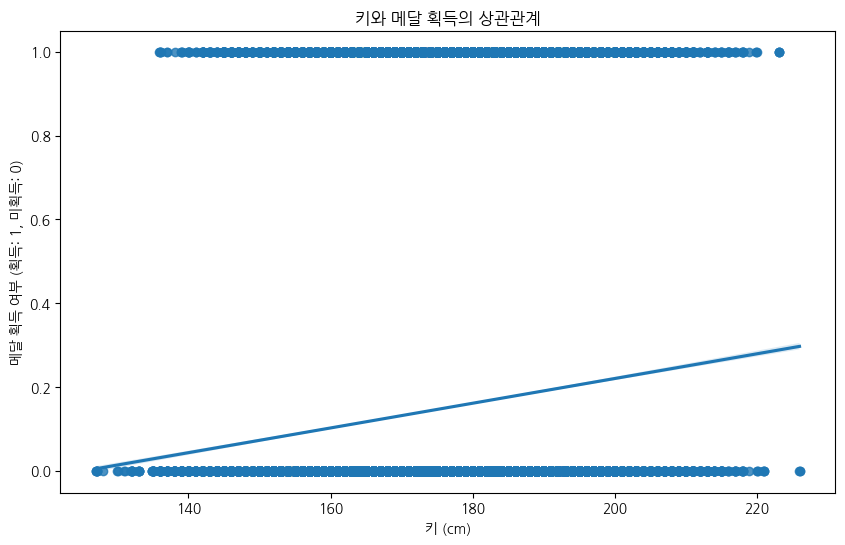

================================ Human Message =================================

키와 메달 획득과의 상관관계를 보여주세요. regplot 그래프로 그려주세요.



================================== Ai Message ==================================

제공된 코드는 키와 메달 획득 여부 사이의 관계를 시각화하는 regplot 그래프를 그립니다.

**그래프 분석:**

*   **제목:** '키와 메달 획득의 상관관계'는 그래프가 키와 메달 획득 사이의 관계를 나타냄을 명확히 합니다.
*   **축 레이블:** x축은 '키 (cm)'로, 참가자들의 키를 센티미터 단위로 나타냅니다. y축은 '메달 획득 여부 (획득: 1, 미획득: 0)'로, 메달 획득 여부를 이진 변수(1 또는 0)로 나타냅니다.
*   **데이터 포인트:** 그래프는 개별 데이터 포인트를 표시하며, 각 포인트는 특정 키와 메달 획득 여부의 조합을 나타냅니다. `x_jitter=.1`은 x축 방향으로 데이터 포인트를 약간 흩뿌려 데이터 밀집으로 인한 겹침을 줄입니다.
*   **회귀선:** regplot은 데이터 포인트에 가장 적합한 회귀선을 표시합니다. 이 선은 키와 메달 획득 여부 사이의 전반적인 추세 또는 관계를 나타냅니다. 선의 기울기와 방향은 관계의 강도와 방향을 나타냅니다.

**인사이트:**

*   **상관관계 시각화:** regplot은 키가 큰 선수들이 메달을 획득할 가능성이 더 높은지 또는 낮은지 여부를 시각적으로 평가하는 데 도움이 됩니다. 회귀선이 위쪽으로 향하면 키가 클수록 메달 획득 가능성이 높다는 것을 의미하고, 아래쪽으로 향하면 그 반대를 의미합니다.
*   **데이터 분포:** 데이터 포인트의 분포는 특정 키 범위에서 메달 획득이 더 일반적인지 여부에 대한 인사이트를 제공합니다.
*   **이상치:** 그래프에서 회귀선에서 멀리 떨어진 이상

<Figure size 640x480 with 0 Axes>

In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "996"})

streaming("키와 메달 획득과의 상관관계를 보여주세요. regplot 그래프로 그려주세요.", config)

================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.



================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.





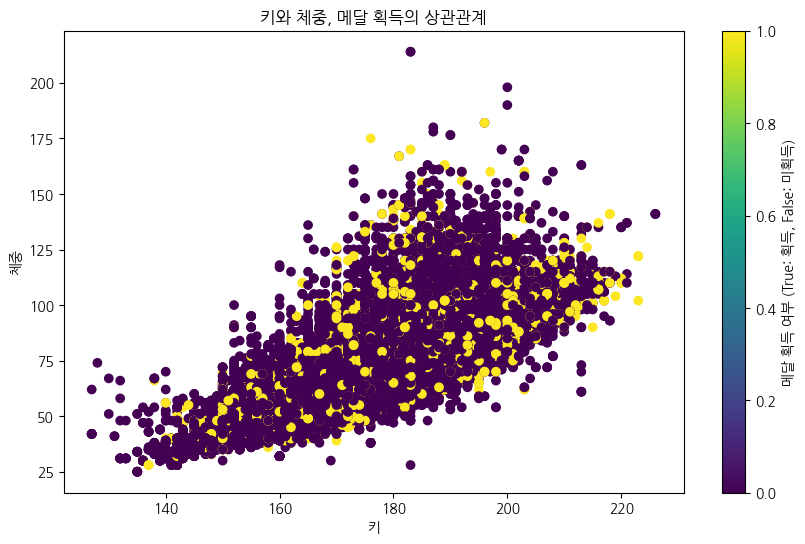

================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.



================================== Ai Message ==================================

제공된 그림은 키와 체중의 상관관계를 나타내는 산점도이며, 각 점의 색깔은 메달 획득 여부를 나타냅니다.

**인사이트:**

*   **전반적인 분포:** 그림에서 키와 체중은 양의 상관관계를 보입니다. 즉, 키가 클수록 체중이 나가는 경향이 있습니다.
*   **메달 획득 그룹:** 메달을 획득한 그룹(밝은 색)은 메달을 획득하지 못한 그룹(어두운 색)에 비해 상대적으로 키와 체중이 더 큰 쪽에 분포하는 경향이 있습니다. 이는 키와 체중이 운동 능력과 관련이 있을 수 있음을 시사합니다.
*   **특이점:** 그림에서 특정 키와 체중 범위에 메달을 획득한 선수와 획득하지 못한 선수가 모두 분포하고 있습니다. 이는 키와 체중 외에 다른 요인(예: 운동 종목, 훈련량, 개인의 재능 등)도 메달 획득에 영향을 미칠 수 있음을 의미합니다.
*   **색상 막대:** 색상 막대는 0부터 1까지의 값을 가지며, 1에 가까울수록 메달을 획득했을 가능성이 높습니다.
*   **크기:** 그래프의 크기는 가로 10, 세로 6입니다.





<Figure size 640x480 with 0 Axes>

In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "999"})

streaming("키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.", config)

================================ Human Message =================================

키와 메달 획득과의 상관관계를 보여주세요. boxplot 그래프로 그려주세요. 그리고 그래프에서 이상치로 보이는 선수들의 목록을 z-score나 IQR 방법을 사용해서 찾아서 표로 보여주세요.



================================ Human Message =================================

키와 메달 획득과의 상관관계를 보여주세요. boxplot 그래프로 그려주세요. 그리고 그래프에서 이상치로 보이는 선수들의 목록을 z-score나 IQR 방법을 사용해서 찾아서 표로 보여주세요.





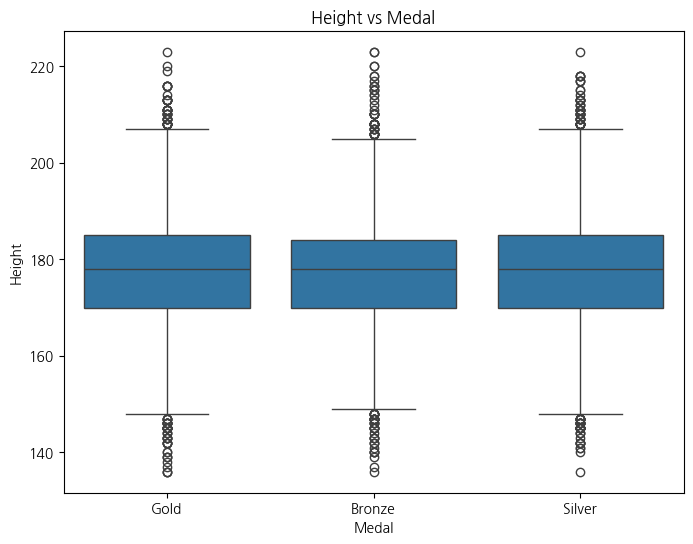

이상치 선수 목록 (Z-score > 3):
                                           Name  Height   Medal
443                          Mamdouh Abdelrehim   207.0     NaN
493                        Maizurah Abdul Rahim   147.0     NaN
820                    Abdelhalim Muhammad Abou   210.0     NaN
833                     Essameldin Abou El-Nein   205.0     NaN
1186                       Kieron Robert Achara   208.0     NaN
...                                         ...     ...     ...
270185  Kimberley Lyn "Kim" Zmeskal (-Burdette)   139.0     NaN
270186  Kimberley Lyn "Kim" Zmeskal (-Burdette)   139.0     NaN
270740                       Eurelijus ukauskas   218.0  Bronze
270741                       Eurelijus ukauskas   218.0  Bronze
270742                       Eurelijus ukauskas   218.0     NaN

[2037 rows x 3 columns]

이상치 선수 목록 (IQR):
                                   Name  Height Medal
2                   Gunnar Nielsen Aaby     NaN   NaN
3                  Edgar Lindenau Aabye     NaN  Gold
29

<Figure size 640x480 with 0 Axes>

In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "985"})

streaming("키와 메달 획득과의 상관관계를 보여주세요. boxplot 그래프로 그려주세요. 그리고 그래프에서 이상치로 보이는 선수들의 목록을 z-score나 IQR 방법을 사용해서 찾아서 표로 보여주세요.", config)
